In [ ]:
!pip install av

     |████████████████████████████████| 37.2 MB 169 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%matplotlib inline
import os
import torchvision, torch
import numpy as np
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

In [ ]:
def get_freq(audio_clip, audio_fps):
    size = len(audio_clip)
    audio_freq = np.fft.fft(audio_clip)[:size//2] / size
    audio_freq[1:] *= 2

    # to get more accurate peak frequency
    mp = 15 # multiplier
    sd = size * mp # size dense
    audio_freq_dense = np.zeros(sd // 2)
    audio_freq_dense[::mp] = np.abs(audio_freq)

    audio_freq_dense = gaussian_filter1d(audio_freq_dense, sigma=10*mp)

    freqs = np.fft.fftfreq(sd, 1/audio_fps)[:sd//2]
    peak_freq = freqs[np.argmax(audio_freq_dense)]
    return peak_freq


def check_valid_d2t(d_intervals):
    return all((
        0 <= np.max(d_intervals) < 0.1,
        -0.1 < np.min(d_intervals) <= 0
    ))

In [ ]:
path = '/gdrive/My Drive/CS492I/2021F_CS492/learning data/'
video_name = os.path.join(path, 'paper_e.mp4')
video, audio, metadata = torchvision.io.read_video(video_name)

In [ ]:
metadata['audio_fps']

44100

In [ ]:
kwargs = {'peak_height': 5e-5, 'peak_t_tolerance': 0.07}
start_time = 350
end_time = 370

[350.70485682   0.99999944]


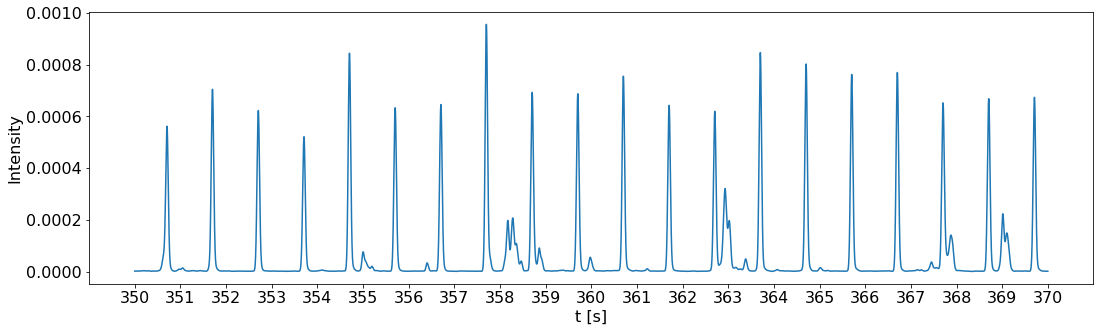

In [ ]:
settings = {
    'peak_t_tolerance': 0.07,
    'peak_height': 2e-4
}

settings.update(kwargs)

audio_fps = metadata['audio_fps']
# assert audio_fps == 48000

start_point = audio_fps * start_time
end_point =audio_fps * end_time

t = np.arange(start_point, end_point) / audio_fps
clip = audio[0, start_point:end_point] ** 2
clip = clip.numpy()
clip = gaussian_filter1d(clip, 1000)

peaks, peak_properties = find_peaks(clip, distance=int(audio_fps * 0.75), height=settings['peak_height'])
peak_t = t[peaks]

peak_i = np.arange(len(peak_t))
fit = np.polynomial.polynomial.polyfit(peak_i, peak_t, deg=1)
linear_peak_t = peak_i * fit[1] + fit[0]
linear_error = np.abs(linear_peak_t - peak_t)

# substitute peaks which error is bigger than tolerance
bad_peaks = linear_error > settings['peak_t_tolerance']
peak_t[bad_peaks] = linear_peak_t[bad_peaks]


############################
print(fit)
plt.rcParams['figure.figsize'] = [18, 5]
plt.rcParams['font.size'] = 16
plt.plot(t, clip, '-')
plt.xticks(np.arange(min(t), max(t)+1, 1.0));
plt.xlabel('t [s]')
plt.ylabel('Intensity')
############################


# assert 1.01 < fit[1] < 1.03
assert check_valid_d2t(np.diff(peak_t, n=2))

audio_points = peak_t * audio_fps

offset = audio_fps // 30
freqs = []
for audio_point in audio_points:
    aud_mid_point = round(audio_point)
    aud_start_point = aud_mid_point - offset
    aud_end_point = aud_mid_point + offset
    aud_clip = audio[0, aud_start_point:aud_end_point]
    freqs.append(get_freq(aud_clip.numpy(), audio_fps))

freqs = np.array(freqs)

# for i in range(3):
#     assert np.all(freqs[i::3] > 600) or np.all(freqs[i::3] < 600)

# peak_frames = np.round(peak_t * metadata['video_fps']).astype(np.int64)
# hand_shape_frames = peak_frames[freqs > 600]


In [ ]:
linear_error[31:35]

In [ ]:
np.diff(t[peaks]).max()

In [ ]:
np.diff(t[peaks][:400], n=1)

In [ ]:
peak_frames = np.round(peak_t * metadata['video_fps']).astype(np.int64)
hand_shape_frames = peak_frames[1::3]

In [ ]:
freqs

array([1738., 1741., 1742., 1732., 1737., 1736., 1741., 1739., 1737.,
       1739., 1741., 1747., 1748., 1739., 1738., 1741., 1736., 1733.,
       1740., 1728., 1729., 1727., 1737., 1734., 1729., 1732., 1738.,
       1735., 1738., 1738., 1738., 1745., 1743., 1741., 1747., 1743.,
       1740., 1733., 1739., 1736., 1738., 1743., 1739., 1746., 1743.,
       1738., 1745., 1744., 1738., 1745., 1746., 1733., 1731., 1729.,
       1740., 1732., 1743., 1734., 1745., 1732., 1727., 1738., 1729.,
       1736., 1743., 1733., 1727., 1746., 1736., 1737., 1740., 1731.,
       1741., 1748., 1734.])

In [ ]:
bad_peaks

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
hand_shape_frames

array([ 8441,  8513,  8585,  8657,  8729,  8801,  8873,  8945,  9017,
        9089,  9161,  9233,  9305,  9377,  9449,  9521,  9593,  9665,
        9737,  9809,  9881,  9953, 10025, 10097, 10169])

In [ ]:
print(np.argmax(np.diff(peak_t, n=1)))
for x in np.ndenumerate(np.diff(peak_t, n=1)):
    print(*x)

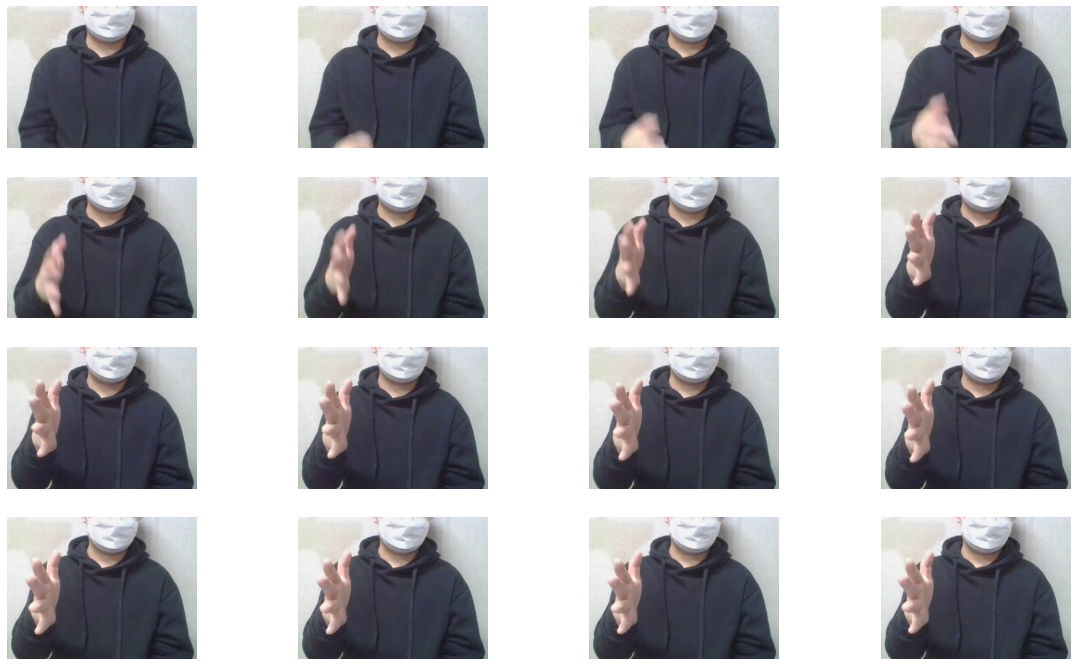

In [ ]:
plt.figure(figsize=(20, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(video[8441 + (72*2) - 12 + i].numpy())
    plt.axis('off')

In [ ]:
print(video.shape[0] / metadata['video_fps'], audio.shape[1] / metadata['audio_fps'])
print(metadata['video_fps'])

614.3526666666667 614.272
29.847677067135162


In [ ]:
# tmp = (np.diff(t[find_peaks(clip, distance=int(audio_fps * 0.75), height=5e-5)[0]], n=0))

# for idx, val in np.ndenumerate(tmp):
#     print(idx, val)

In [ ]:
np.save(video_name + '.npy', hand_shape_frames)
print(np.diff(hand_shape_frames, n=1))

[72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72]


In [ ]:
np.diff(np.load(video_name +'.npy'))

array([72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72])

In [ ]:
np.load('/gdrive/My Drive/CS492I/2021F_CS492/learning data/paper_e.mp4.npy').size

25